In [280]:
# This is my own work: Huilan You 

# ========================================================================
# Copyright 2018 Emory University
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ========================================================================
import csv
from types import SimpleNamespace
from collections import Counter

In [281]:
def load_course_info(csv_file):
    def skip(i, row):
        return i == 0 or int(row[11]) == 0 or row[12].strip() == '' or row[14].strip() != 'Active'

    def info(row):
        # term is normalized to (year, term_id) (e.g., 5181 -> (2018, 1))
        # term_id = 1: Spring, 6: Summer, 9: Fall
        r = row[0]
        term = (2000 + int((int(r) - 5000) / 10), int(r[-1]))

        # name = lastname,firstname
        r = row[12].split(',')
        instructor = (r[0].strip(), r[1].strip())

        return SimpleNamespace(
            term=term,
            subject=row[3].strip(),
            catalog=row[4].strip(),
            section=row[5].strip(),
            title=row[6].strip(),
            min_hours=int(row[8]),
            max_hours=int(row[9]),
            enrollment=int(row[11]),
            instructor=instructor)

    with open(csv_file) as fin:
        reader = csv.reader(fin)
        course_info = [info(row) for i, row in enumerate(reader) if not skip(i, row)]

    return course_info


In [282]:

def course_by_terms(course_info):
    fall_courses=0;
    fall_list = []
    spring_list = []
    summer_list = []
    for c in course_info:
        if c.term[1] == 9:
            fall_courses = (*c.term, c.subject, c.catalog)
            fall_list.append(fall_courses)
        elif c.term[1] == 1:
            spring_courses = (*c.term, c.subject, c.catalog)
            spring_list.append(spring_courses)
        elif c.term[1] == 6:
            summer_courses = (*c.term, c.subject, c.catalog)
            summer_list.append(summer_courses) 
  
    return(Counter(t[2:] for t in fall_list), Counter(t[2:] for t in spring_list),Counter(t[2:] for t in summer_list))


In [296]:
def course_trend(course_info):
    """
    :param course_info: the output of load_course_info().
    :return: a dictionary where the key is a course ID (e.g., 'CS170') and
             the value is the likelihood of each course being offered in the Fall and Spring terms (e.g., (0.3, 0.7).
    """
    
# TODO: to be filled
    courses=course_by_terms(course_info)
    total_count={}

    # make sure total covers all course since some classes only offer in one term 
    for course in courses[0]:
        total=courses[0][course]+courses[1][course]+courses[2][course]
        total_count[course]=total
    for course in courses[1]:
        total=courses[0][course]+courses[1][course]+courses[2][course]
        if course not in total_count:
            total_count[course]=total
    for course in courses[2]:
        total=courses[0][course]+courses[1][course]+courses[2][course]
        if course not in total_count:
            total_count[course]=total
    fall_average={course:count/total_count[course] for course,count in courses[0].items()}
    spring_average={course:count/total_count[course] for course,count in courses[1].items()}
    summer_average={course:count/total_count[course] for course,count in courses[2].items()}

    result=[]
    for course in total_count:

        result.append({' '.join(course):(fall_average[course] if course in fall_average else 0,spring_average[course] \
                                         if course in spring_average else 0,summer_average[course] \
                                         if course in summer_average else 0)})

    print(result)
return result 

[{'CS 170': (0.5047619047619047, 0.42857142857142855, 0.06666666666666667)},
 {'CS 171': (0.34210526315789475, 0.4473684210526316, 0.21052631578947367)},
 {'CS 325': (0.14285714285714285, 0.8571428571428571, 0)},
 {'CS 375R': (0.3333333333333333, 0.6666666666666666, 0)},
 {'CS 497R': (0.48, 0.48, 0.04)},
 {'CS 557': (0.6666666666666666, 0.3333333333333333, 0)},
 {'CS 572': (0.2, 0.8, 0)},
 {'CS 596R': (0.4, 0.2, 0.4)},
 {'CS 597R': (0.3655913978494624, 0.4838709677419355, 0.15053763440860216)},
 {'CS 598R': (0.42592592592592593, 0.48148148148148145, 0.09259259259259259)},
 {'CS 599R': (0.375, 0.575, 0.05)},
 {'CS 700R': (0.47619047619047616, 0.5238095238095238, 0)},
 {'CS 730': (0.3333333333333333, 0.6666666666666666, 0)},
 {'CS 799R': (0.4166666666666667, 0.475, 0.10833333333333334)},
 {'CS 130R': (0.3333333333333333, 0.6666666666666666, 0)},
 {'CS 370': (0.14285714285714285, 0.8571428571428571, 0)},
 {'CS 255': (0.5882352941176471, 0.4117647058823529, 0)},
 {'CS 377': (0.769230769230

In [285]:
def is_research_course(catalog):
    return catalog != '130R' and 'R' in catalog

def is_undergraduate_course(catalog):
    return int(catalog[0])<5



In [286]:

def special_topics(course_info, include_research=False, include_undergraduate=False):
    """
    :param course_info: the output of load_course_info().
    :return: a dictionary where the key is a professor name (e.g., 'Jinho D Choi') and the value is the professor's
             special graduate courses excluding research courses ranked in descending order.
    """
    d = {}
    for c in course_info:
        if (include_research or not is_research_course(c.catalog)) and \
        (include_undergraduate or not is_undergraduate_course(c.catalog)) :
            key = c.instructor
            val = (c.subject+c.catalog)
            if key in d: d[key].add(val)
            else:
                  d[key] = {val}
                    
    # Change the set to list in a reversed order
    for key, value in d.items(): 
        value=sorted(list(value),reverse=True)
        d[key]=value

    
    return d
    
       


In [287]:
def courses_by_instructors(course_info, include_research=False, include_undergraduate=False):
    d = {}
    for c in course_info:
        if (include_research or not is_research_course(c.catalog)) and \
        (include_undergraduate or not is_undergraduate_course(c.catalog)):
            key = c.instructor
            val = (*c.term, c.subject, c.catalog)
            if key in d: d[key].add(val)
            else: d[key] = {val}

    return {k: Counter([t[2:] for t in v]) for k, v in d.items()}




In [288]:
def professor_frequency(prof_course_dict):
    return Counter([k for v in prof_course_dict.values() for k in v.keys()])

prof_freq = professor_frequency(prof_course_dict)
print(prof_freq)

Counter({('CS', '584'): 18, ('CS', '730'): 3, ('CS', '590'): 3, ('CS', '534'): 3, ('CS', '540'): 3, ('CS', '572'): 2, ('CS', '571'): 2, ('CS', '554'): 2, ('CS', '558'): 2, ('CS', '574'): 2, ('CS', '570'): 2, ('CS', '557'): 1, ('CS', '559'): 1, ('CS', '561'): 1, ('CS', '524'): 1, ('CS', '526'): 1, ('CS', '740'): 1, ('CS', '563'): 1, ('CS', '556'): 1, ('CS', '551'): 1, ('CS', '580'): 1, ('CS', '720'): 1, ('CS', '555'): 1, ('CS', '573'): 1})


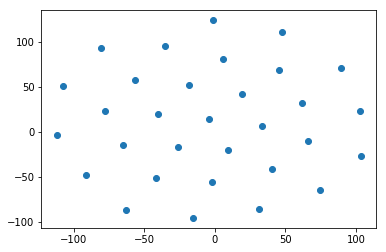

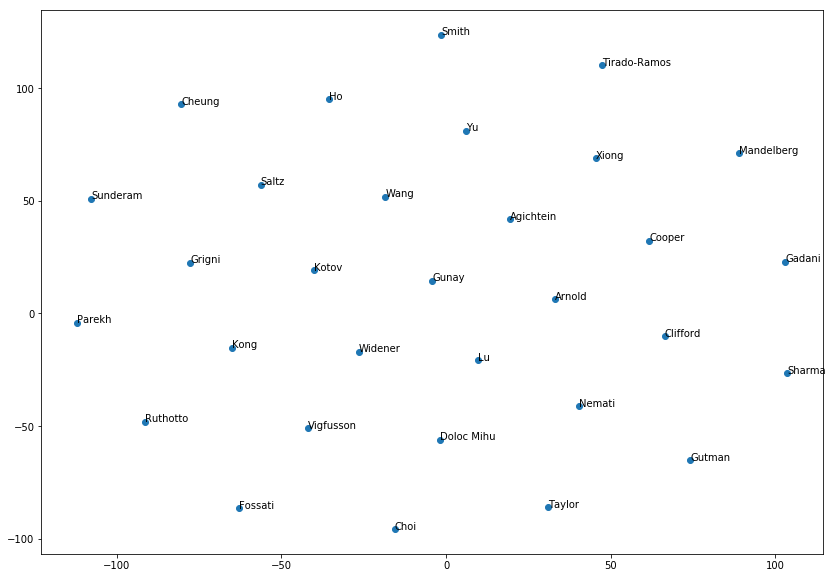

In [299]:
import matplotlib.pyplot as plt
import math
def vector_plot(course_info):
    """
    :param course_info: the output of load_course_info().
    """
    prof_course_dict = courses_by_instructors(course_info)
    prof_freq = professor_frequency(prof_course_dict)
    N = len(prof_course_dict)
    course_dict = {c: i for i, c in enumerate(sorted(list(prof_freq.keys())))}
    p2v = {}
    
    for prof_name, counts in prof_course_dict.items():
        vec = np.zeros(len(course_dict))
        
        for k, v in counts.items():
            if k in course_dict:
                i = course_dict[k]
                vec[i] = v * math.log(N / prof_freq[k])
        
        p2v[prof_name] = vec
profs = sorted(p2v.keys())
vectors = np.array([p2v[p] for p in profs])
from sklearn.manifold import TSNE

xy = TSNE(n_components=2).fit_transform(vectors)
fig, ax = plt.subplots()
ax.scatter(xy[:,0], xy[:,1])
plt.show()

fig, ax = plt.subplots()
fig.set_size_inches(14, 10)

x = xy[:,0]
y = xy[:,1]
ax.scatter(x, y)

for i, p in enumerate(profs):
    ax.annotate(p[0], (x[i], y[i]))
    
plt.show()

In [298]:
if __name__ == '__main__':
    csv_file = 'cs_courses_2008_2018.csv'
    course_info = load_course_info(csv_file)
    trend = course_trend(course_info)
    topics = special_topics(course_info)
    vector_plot(course_info)
    print(topics)
    print(trend)

[{'CS 170': (0.5047619047619047, 0.42857142857142855, 0.06666666666666667)}, {'CS 171': (0.34210526315789475, 0.4473684210526316, 0.21052631578947367)}, {'CS 325': (0.14285714285714285, 0.8571428571428571, 0)}, {'CS 375R': (0.3333333333333333, 0.6666666666666666, 0)}, {'CS 497R': (0.48, 0.48, 0.04)}, {'CS 557': (0.6666666666666666, 0.3333333333333333, 0)}, {'CS 572': (0.2, 0.8, 0)}, {'CS 596R': (0.4, 0.2, 0.4)}, {'CS 597R': (0.3655913978494624, 0.4838709677419355, 0.15053763440860216)}, {'CS 598R': (0.42592592592592593, 0.48148148148148145, 0.09259259259259259)}, {'CS 599R': (0.375, 0.575, 0.05)}, {'CS 700R': (0.47619047619047616, 0.5238095238095238, 0)}, {'CS 730': (0.3333333333333333, 0.6666666666666666, 0)}, {'CS 799R': (0.4166666666666667, 0.475, 0.10833333333333334)}, {'CS 130R': (0.3333333333333333, 0.6666666666666666, 0)}, {'CS 370': (0.14285714285714285, 0.8571428571428571, 0)}, {'CS 255': (0.5882352941176471, 0.4117647058823529, 0)}, {'CS 377': (0.7692307692307693, 0.230769230